In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import pm4py  # install pm4py using: pip install pm4py

# Load the XES event log international declaration
file_path = '/Users/mac/Desktop/MT S2P/BPI Challenge 2018_1_all/BPI Challenge 2018.xes'
event_log = pm4py.read_xes('/Users/mac/Desktop/MT S2P/BPI Challenge 2018_1_all/BPI Challenge 2018.xes')
df = pm4py.convert_to_dataframe(event_log)

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/43809 [00:00<?, ?it/s]

: 

Stability Score (Before Filtering): 99.41%


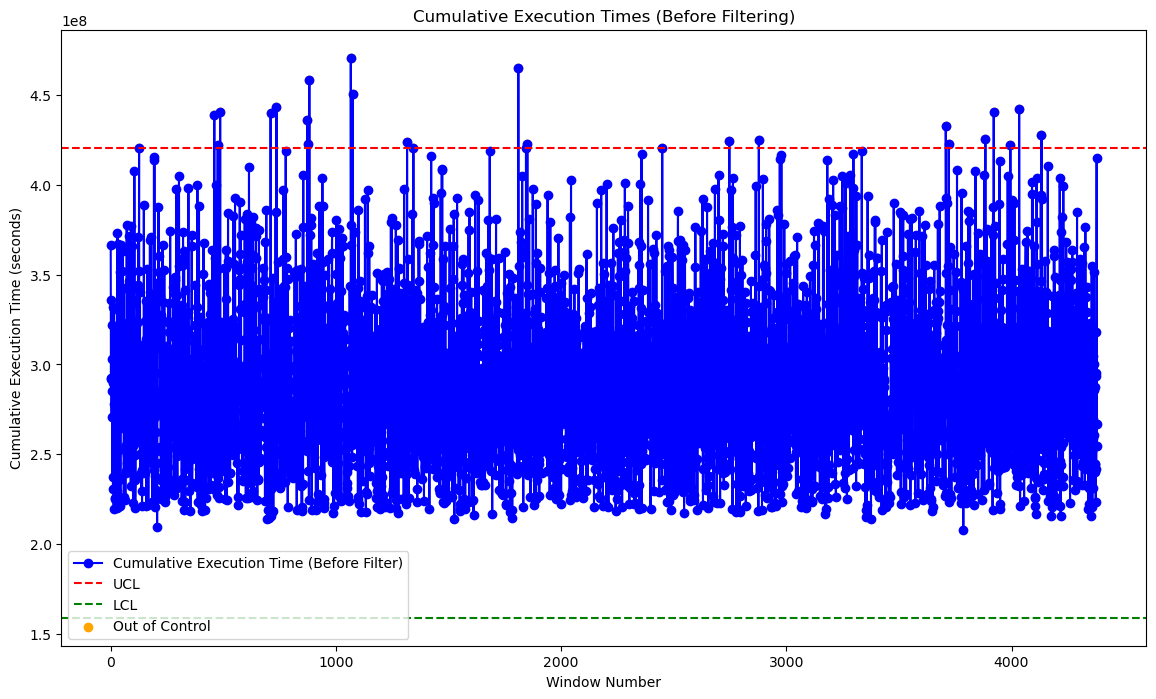

Stability Score (After Filtering): 99.41%


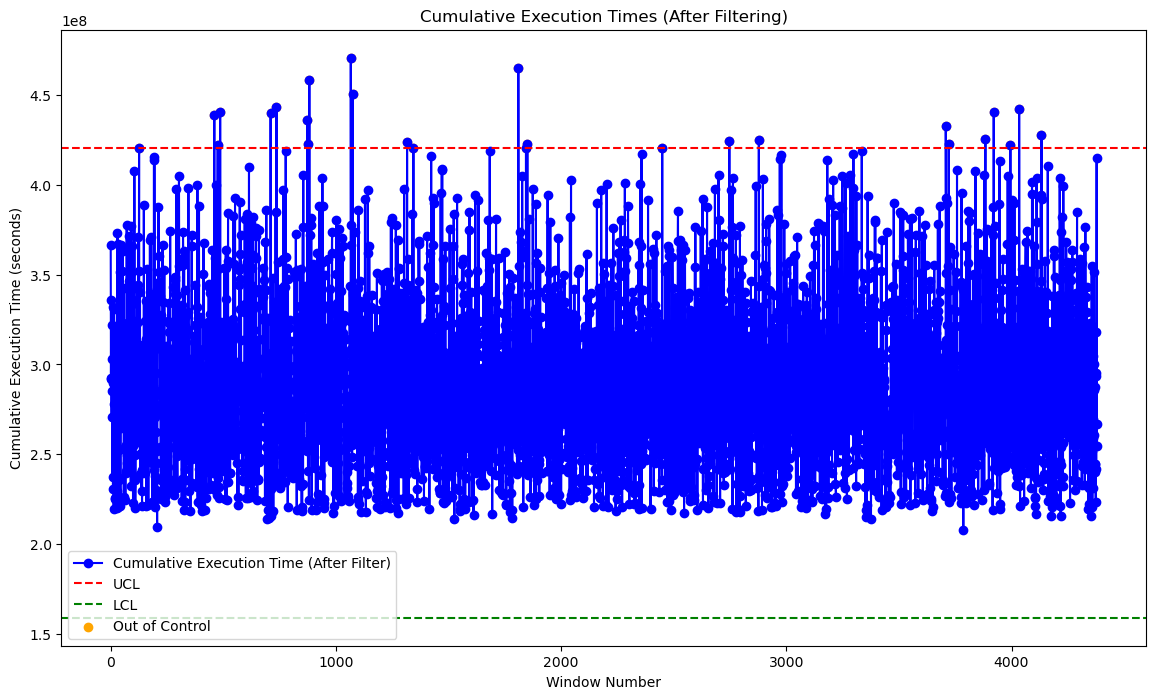

In [11]:
# apply 10 window 最终版 filter前后：
import pandas as pd
import matplotlib.pyplot as plt

# 假设数据已加载并转换为时间戳
df['Complete Timestamp'] = pd.to_datetime(df['time:timestamp'])

# Step 1: 计算每个 Case 的执行时间 (未过滤数据)
execution_time_before_filter = df.groupby('case:concept:name').apply(
    lambda x: (x['Complete Timestamp'].max() - x['Complete Timestamp'].min()).total_seconds()
).reset_index(name='Execution Time')

# Step 2: 计算每 10-case 窗口的累计执行时间
window_size = 10
execution_time_before_filter['Window Number'] = execution_time_before_filter.index // window_size
cumulative_execution_time_before_filter = execution_time_before_filter.groupby('Window Number')['Execution Time'].sum().reset_index(name='Cumulative Execution Time')

# Step 3: 计算累计执行时间的均值和标准差
mean_cumulative_time_before_filter = cumulative_execution_time_before_filter['Cumulative Execution Time'].mean()
std_cumulative_time_before_filter = cumulative_execution_time_before_filter['Cumulative Execution Time'].std()

# Step 4: 计算控制限
UCL_before_filter = mean_cumulative_time_before_filter + 3 * std_cumulative_time_before_filter
LCL_before_filter = max(mean_cumulative_time_before_filter - 3 * std_cumulative_time_before_filter, 0)

# Step 5: 标记超出控制限的窗口
cumulative_execution_time_before_filter['Out of Control'] = (cumulative_execution_time_before_filter['Cumulative Execution Time'] > UCL_before_filter) | \
                                                            (cumulative_execution_time_before_filter['Cumulative Execution Time'] < LCL_before_filter)

# Step 6: 打印稳定性分数
stability_score_before_filter = 1 - cumulative_execution_time_before_filter['Out of Control'].mean()
print(f"Stability Score (Before Filtering): {stability_score_before_filter:.2%}")

# Step 7: 绘制累计执行时间与控制限
plt.figure(figsize=(14, 8))
plt.plot(
    cumulative_execution_time_before_filter['Window Number'],
    cumulative_execution_time_before_filter['Cumulative Execution Time'],
    marker='o',
    linestyle='-',
    color='blue',
    label='Cumulative Execution Time (Before Filter)'
)
plt.axhline(UCL_before_filter, color='red', linestyle='--', label='UCL')
plt.axhline(LCL_before_filter, color='green', linestyle='--', label='LCL')
out_of_control_before_filter = cumulative_execution_time_before_filter['Out of Control']
plt.scatter(
    cumulative_execution_time_before_filter['Window Number'][out_of_control_before_filter],
    cumulative_execution_time_before_filter['Cumulative Execution Time'][out_of_control_before_filter],
    color='orange',
    label='Out of Control'
)
plt.title('Cumulative Execution Times (Before Filtering)')
plt.xlabel('Window Number')
plt.ylabel('Cumulative Execution Time (seconds)')
plt.legend()
plt.show()

# Step 1: 过滤掉执行时间为 0 的数据
execution_time_after_filter = execution_time_before_filter[execution_time_before_filter['Execution Time'] > 0]

# Step 2: 计算每 10-case 窗口的累计执行时间
execution_time_after_filter['Window Number'] = execution_time_after_filter.index // window_size
cumulative_execution_time_after_filter = execution_time_after_filter.groupby('Window Number')['Execution Time'].sum().reset_index(name='Cumulative Execution Time')

# Step 3: 计算累计执行时间的均值和标准差
mean_cumulative_time_after_filter = cumulative_execution_time_after_filter['Cumulative Execution Time'].mean()
std_cumulative_time_after_filter = cumulative_execution_time_after_filter['Cumulative Execution Time'].std()

# Step 4: 计算控制限
UCL_after_filter = mean_cumulative_time_after_filter + 3 * std_cumulative_time_after_filter
LCL_after_filter = max(mean_cumulative_time_after_filter - 3 * std_cumulative_time_after_filter, 0)

# Step 5: 标记超出控制限的窗口
cumulative_execution_time_after_filter['Out of Control'] = (cumulative_execution_time_after_filter['Cumulative Execution Time'] > UCL_after_filter) | \
                                                           (cumulative_execution_time_after_filter['Cumulative Execution Time'] < LCL_after_filter)

# Step 6: 打印稳定性分数
stability_score_after_filter = 1 - cumulative_execution_time_after_filter['Out of Control'].mean()
print(f"Stability Score (After Filtering): {stability_score_after_filter:.2%}")

# Step 7: 绘制累计执行时间与控制限
plt.figure(figsize=(14, 8))
plt.plot(
    cumulative_execution_time_after_filter['Window Number'],
    cumulative_execution_time_after_filter['Cumulative Execution Time'],
    marker='o',
    linestyle='-',
    color='blue',
    label='Cumulative Execution Time (After Filter)'
)
plt.axhline(UCL_after_filter, color='red', linestyle='--', label='UCL')
plt.axhline(LCL_after_filter, color='green', linestyle='--', label='LCL')
out_of_control_after_filter = cumulative_execution_time_after_filter['Out of Control']
plt.scatter(
    cumulative_execution_time_after_filter['Window Number'][out_of_control_after_filter],
    cumulative_execution_time_after_filter['Cumulative Execution Time'][out_of_control_after_filter],
    color='orange',
    label='Out of Control'
)
plt.title('Cumulative Execution Times (After Filtering)')
plt.xlabel('Window Number')
plt.ylabel('Cumulative Execution Time (seconds)')
plt.legend()
plt.show()


In [2]:
# Step 1: Calculate execution time for each case
# Calculate execution times for each case ID
df['Complete Timestamp'] = pd.to_datetime(df['time:timestamp'])
execution_times = df.groupby('case:concept:name').apply(
    lambda x: (x['Complete Timestamp'].max() - x['Complete Timestamp'].min()).total_seconds()
).reset_index(name='Execution Time')
# Step 2: Calculate UCL and LCL based on the mean and standard deviation
mean_execution_time = execution_times['Execution Time'].mean()
std_execution_time = execution_times['Execution Time'].std()

UCL = mean_execution_time + 3 * std_execution_time
LCL = mean_execution_time - 3 * std_execution_time if mean_execution_time - 3 * std_execution_time > 0 else 0
print(f"Mean Execution Time: {mean_execution_time:.2f} seconds")
print(f"Standard Deviation of Execution Time: {std_execution_time:.2f} seconds")
print(f"Upper Control Limit (UCL): {UCL:.2f} seconds")
print(f"Lower Control Limit (LCL): {LCL:.2f} seconds")
execution_times['Within Limits'] = execution_times['Execution Time'].apply(lambda x: LCL <= x <= UCL)
print(execution_times.head())

Mean Execution Time: 28974460.25 seconds
Standard Deviation of Execution Time: 13735086.65 seconds
Upper Control Limit (UCL): 70179720.20 seconds
Lower Control Limit (LCL): 0.00 seconds
  case:concept:name  Execution Time  Within Limits
0  0002505cb62792e4    7.159646e+07          False
1  0002a55a6130cec8    2.655251e+07           True
2  0004ff62053a60ce    4.030541e+07           True
3  000612b48d30de74    4.298327e+07           True
4  0006cc909ce508b0    3.571710e+07           True


In [1]:
import matplotlib.pyplot as plt

# Calculate execution times for each case ID
execution_times = df.groupby('case:concept:name').apply(
    lambda x: (x['Complete Timestamp'].max() - x['Complete Timestamp'].min()).total_seconds()
).reset_index(name='Execution Time')

# Calculate mean and standard deviation of execution times
mean_execution_time = execution_times['Execution Time'].mean()
std_execution_time = execution_times['Execution Time'].std()

# Calculate Control Limits
UCL = mean_execution_time + 3 * std_execution_time
LCL = max(mean_execution_time - 3 * std_execution_time, 0)  # Set LCL to 0 if it goes negative

# General plot for all windows together
all_case_ids = execution_times['case:concept:name']
all_exec_times = execution_times['Execution Time']
all_out_of_control = (all_exec_times > UCL) | (all_exec_times < LCL)

plt.figure(figsize=(14, 8))
plt.plot(all_case_ids, all_exec_times, marker='o', linestyle='-', color='blue', label='Execution Time')
plt.axhline(UCL, color='red', linestyle='--', label='UCL')
plt.axhline(LCL, color='green', linestyle='--', label='LCL')
plt.scatter(all_case_ids[all_out_of_control], all_exec_times[all_out_of_control], color='orange', label='Out of Control')
plt.title('Execution Times for All Cases')
plt.xlabel('Case ID')
plt.ylabel('Execution Time (seconds)')
plt.legend()
plt.show()

NameError: name 'df' is not defined

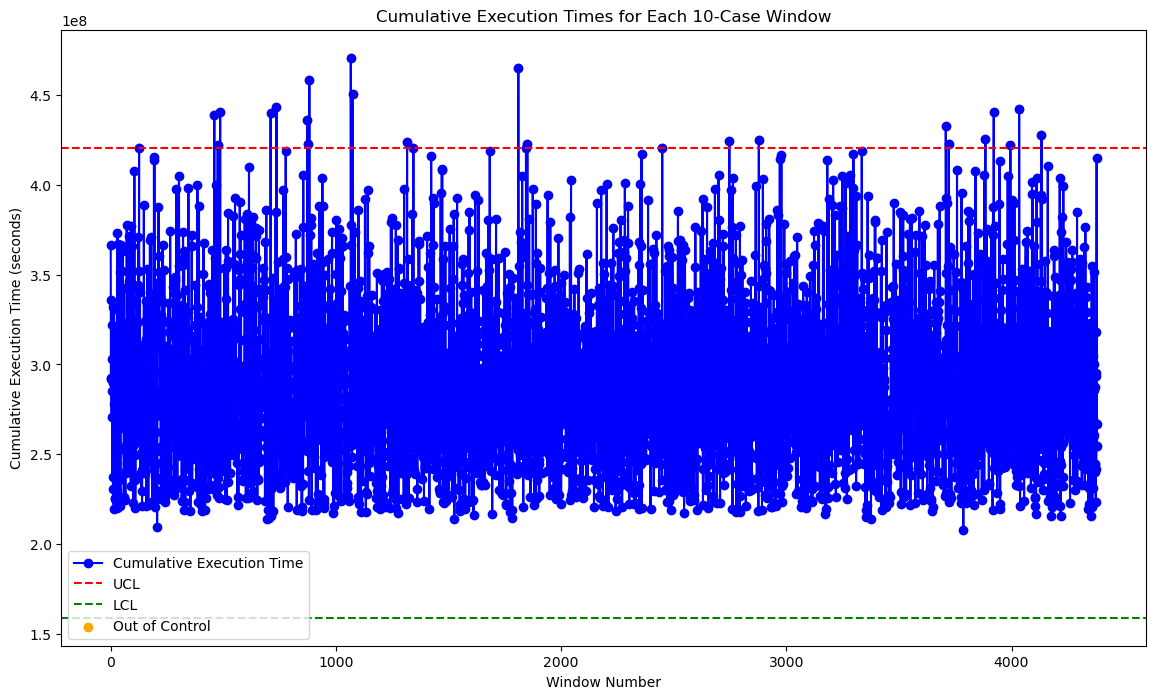

Overall Stability Score: 99.41%
Overall Stability Score: 99.41%
Number of Unstable Windows: 26
Unstable Windows Details:
      Window Number  Cumulative Execution Time  Out of Control
126             126               4.208397e+08            True
460             460               4.391900e+08            True
475             475               4.222629e+08            True
486             486               4.405748e+08            True
710             710               4.404021e+08            True
736             736               4.433095e+08            True
873             873               4.363152e+08            True
878             878               4.231151e+08            True
882             882               4.587496e+08            True
1066           1066               4.709670e+08            True
1075           1075               4.507546e+08            True
1316           1316               4.241770e+08            True
1344           1344               4.206580e+08            Tr

KeyError: "['id'] not in index"

In [4]:
# Calculate cumulative execution time for each 10-case window
window_size = 10
execution_times['Window Number'] = execution_times.index // window_size
cumulative_execution_times = execution_times.groupby('Window Number')['Execution Time'].sum().reset_index(name='Cumulative Execution Time')

# Calculate mean and standard deviation of cumulative execution times
mean_cumulative_time = cumulative_execution_times['Cumulative Execution Time'].mean()
std_cumulative_time = cumulative_execution_times['Cumulative Execution Time'].std()

# Calculate Control Limits for cumulative execution time
UCL = mean_cumulative_time + 3 * std_cumulative_time
LCL = max(mean_cumulative_time - 3 * std_cumulative_time, 0)  # Set LCL to 0 if it goes negative

# Check for windows that exceed control limits
cumulative_execution_times['Out of Control'] = (cumulative_execution_times['Cumulative Execution Time'] > UCL) | \
                                               (cumulative_execution_times['Cumulative Execution Time'] < LCL)

# Plot cumulative execution times for each 10-case window
plt.figure(figsize=(14, 8))
plt.plot(cumulative_execution_times['Window Number'], cumulative_execution_times['Cumulative Execution Time'], marker='o', linestyle='-', color='blue', label='Cumulative Execution Time')
plt.axhline(UCL, color='red', linestyle='--', label='UCL')
plt.axhline(LCL, color='green', linestyle='--', label='LCL')
plt.scatter(cumulative_execution_times['Window Number'][cumulative_execution_times['Out of Control']],
            cumulative_execution_times['Cumulative Execution Time'][cumulative_execution_times['Out of Control']],
            color='orange', label='Out of Control')
plt.title('Cumulative Execution Times for Each 10-Case Window')
plt.xlabel('Window Number')
plt.ylabel('Cumulative Execution Time (seconds)')
plt.legend()
plt.show()

# Check for windows that exceed control limits
cumulative_execution_times['Out of Control'] = (cumulative_execution_times['Cumulative Execution Time'] > UCL) | \
                                               (cumulative_execution_times['Cumulative Execution Time'] < LCL)

# Flag process as unstable if any window falls outside the control limits
unstable_windows = cumulative_execution_times['Out of Control'].sum()
total_windows = len(cumulative_execution_times)
stability_score = ((total_windows - unstable_windows) / total_windows) * 100

# Display stability score
print(f"Overall Stability Score: {stability_score:.2f}%")

# Check for windows that exceed control limits
cumulative_execution_times['Out of Control'] = (cumulative_execution_times['Cumulative Execution Time'] > UCL) | \
                                               (cumulative_execution_times['Cumulative Execution Time'] < LCL)

# Flag process as unstable if any window falls outside the control limits
unstable_windows = cumulative_execution_times[cumulative_execution_times['Out of Control'] == True]

# Extract the corresponding traces that fall within the unstable windows
# Merge the event log dataframe with the cumulative execution times to include 'Cumulative Execution Time'
unstable_traces = df.merge(cumulative_execution_times[['Cumulative Execution Time']], left_index=True, right_index=True)

# Calculate the total number of windows
total_windows = len(cumulative_execution_times)

# Calculate the number of unstable windows
unstable_window_count = len(unstable_windows)

# Calculate overall stability score
stability_score = ((total_windows - unstable_window_count) / total_windows) * 100

# Display results
print(f"Overall Stability Score: {stability_score:.2f}%")
print(f"Number of Unstable Windows: {unstable_window_count}")
print("Unstable Windows Details:")
print(unstable_windows)

# Display the traces that belong to the unstable windows
print("Unstable Traces:")
print(unstable_traces[['id', 'time:timestamp', 'Cumulative Execution Time']])
print(f"Overall Stability Score: {stability_score:.2f}%")

In [5]:
# Set smoothing factor lambda
lambda_ewma = 0.3  # or 0.2 as per your preference

# Define EWMA calculation function
def calculate_ewma(execution_times, lambda_ewma):
    ewma_values = []
    prev_ewma = execution_times[0]  # Initialize EWMA with the first execution time

    for i in range(len(execution_times)):
        if i == 0:
            ewma = prev_ewma  # EWMA for the first point is the first execution time
        else:
            ewma = lambda_ewma * execution_times[i] + (1 - lambda_ewma) * prev_ewma
        ewma_values.append(ewma)
        prev_ewma = ewma  # Update previous EWMA

    return ewma_values

# Calculate EWMA for each 10-trace window
window_size = 10
execution_times['Window Number'] = execution_times.index // window_size
ewma_results = []

for _, window_data in execution_times.groupby('Window Number'):
    ewma_values = calculate_ewma(window_data['Execution Time'].values, lambda_ewma)
    ewma_results.extend(ewma_values)

# Add EWMA results to the execution_times DataFrame
execution_times['EWMA'] = ewma_results

# Plot EWMA values for each window
plt.figure(figsize=(14, 8))
for window_num in execution_times['Window Number'].unique():
    window_data = execution_times[execution_times['Window Number'] == window_num]
    plt.plot(window_data.index, window_data['EWMA'], marker='o', linestyle='-', label=f'Window {window_num + 1}')

plt.title(f'EWMA of Execution Times for Each 10-Case Window (λ={lambda_ewma})')
plt.xlabel('Trace Index')
plt.ylabel('EWMA Execution Time (seconds)')
plt.legend()
plt.show()


# Calculate Control Limits for EWMA
mean_ewma = execution_times['EWMA'].mean()
std_ewma = execution_times['EWMA'].std()
UCL = mean_ewma + 3 * std_ewma
LCL = mean_ewma - 3 * std_ewma

# Identify instability in each window based on control limits and variance
instability_flags = []
window_variances = []

for window_num, window_data in execution_times.groupby('Window Number'):
    window_ewma = window_data['EWMA']
    # Flag window as unstable if any EWMA point crosses UCL or LCL
    unstable = (window_ewma > UCL).any() or (window_ewma < LCL).any()
    instability_flags.append(unstable)
    
    # Calculate variance of EWMA values within the window
    variance = window_ewma.var()
    window_variances.append(variance)

# Calculate overall stability score as the average variance across all windows
average_variance = np.mean(window_variances)
stability_percentage = 100 * (1 - np.mean(instability_flags))

# Display results
print(f"Overall Stability Score (based on EWMA variance): {average_variance:.2f}")
print(f"Percentage of Stable Windows: {stability_percentage:.2f}%")

# Identify instability in each window based on control limits and variance
instability_flags = []
unstable_windows = []  # To store the window numbers of unstable windows

for window_num, window_data in execution_times.groupby('Window Number'):
    window_ewma = window_data['EWMA']
    
    # Flag window as unstable if any EWMA point crosses UCL or LCL
    unstable = (window_ewma > UCL).any() or (window_ewma < LCL).any()
    instability_flags.append(unstable)
    
    if unstable:
        unstable_windows.append(window_num)  # Record the window number if unstable

# Display results
print(f"Unstable Windows (crossed control limits): {unstable_windows}")


/Users/mac/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: Image size of 1143x91809 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1400x800 with 1 Axes>

Overall Stability Score (based on EWMA variance): 37307819442719.98
Percentage of Stable Windows: 87.95%
Unstable Windows (crossed control limits): [0, 5, 7, 15, 31, 45, 51, 54, 62, 75, 82, 90, 91, 92, 94, 97, 122, 126, 134, 159, 165, 169, 176, 180, 183, 189, 194, 199, 209, 220, 267, 268, 277, 281, 287, 292, 303, 308, 320, 325, 330, 334, 343, 345, 350, 365, 376, 380, 385, 390, 392, 401, 402, 410, 414, 421, 434, 435, 438, 448, 449, 460, 464, 469, 475, 486, 490, 494, 504, 507, 510, 511, 513, 521, 537, 538, 546, 552, 569, 570, 573, 579, 582, 594, 597, 604, 611, 632, 636, 643, 644, 645, 658, 659, 661, 663, 664, 680, 682, 688, 691, 697, 717, 733, 736, 743, 747, 751, 756, 775, 785, 790, 797, 819, 822, 828, 830, 834, 853, 873, 878, 882, 920, 929, 938, 950, 952, 957, 968, 982, 995, 1002, 1015, 1027, 1036, 1041, 1044, 1049, 1066, 1067, 1075, 1088, 1089, 1095, 1100, 1106, 1107, 1135, 1157, 1179, 1190, 1196, 1208, 1214, 1223, 1234, 1244, 1253, 1269, 1274, 1285, 1331, 1333, 1340, 1370, 1379, 1385,

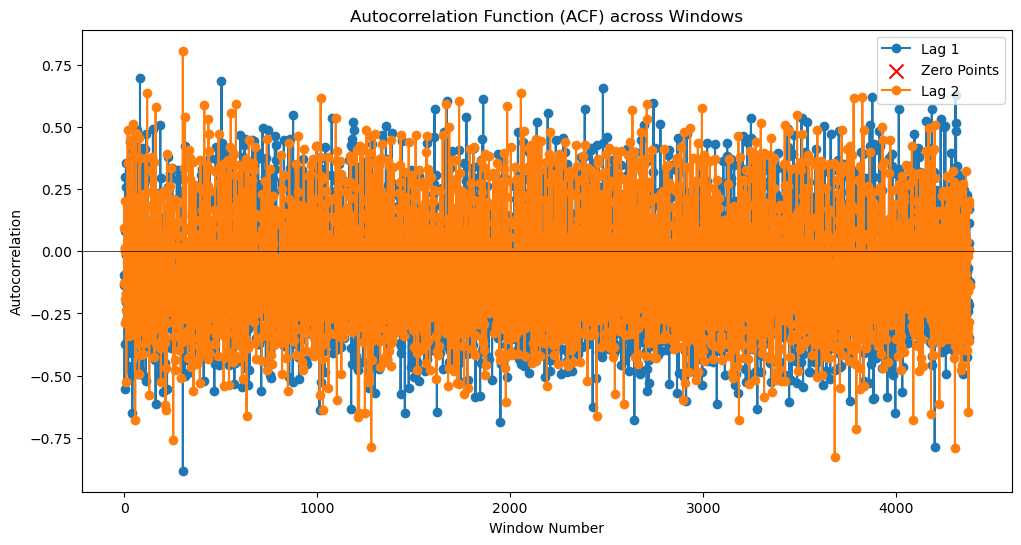

Total windows: 4381
Stable windows: 4361
Stability Score: 99.54%


In [6]:
# Calculate autocorrelation for each window
def calculate_autocorrelation(y, lag):
    mean_y = np.mean(y)
    numerator = np.sum((y[lag:] - mean_y) * (y[:-lag] - mean_y))
    denominator = np.sum((y - mean_y) ** 2)
    
    return numerator / denominator


# Evaluate ACF for each window at multiple lags
lags = [1, 2]  # You can specify more lags if needed
window_acf_results = {}

for window_num, window_data in execution_times.groupby('Window Number'):
    y = window_data['Execution Time'].values
    acf_values = {}
    for lag in lags:
        if len(y) > lag:  # Ensure sufficient data points for the lag
            acf_values[f'Lag {lag}'] = calculate_autocorrelation(y, lag)
        else:
            acf_values[f'Lag {lag}'] = np.nan  # Assign NaN if not enough data for lag
    window_acf_results[window_num] = acf_values

# Convert results to DataFrame for easier plotting and analysis
acf_df = pd.DataFrame(window_acf_results).T
acf_df.columns = [f'Lag {lag}' for lag in lags]

# Plot the ACF for each lag across all windows
plt.figure(figsize=(12, 6))

for lag in lags:
    acf_values = acf_df[f'Lag {lag}'].copy()
    
    # 替换自相关值为0的点为NaN，以在绘图时产生断点
    acf_values[acf_values == 0] = np.nan  
    
    # 绘制自相关值
    plt.plot(acf_df.index, acf_values, marker='o', label=f'Lag {lag}')

    # 在0值的位置添加标记
    zero_positions = acf_df.index[acf_df[f'Lag {lag}'] == 0]
    plt.scatter(zero_positions, np.zeros_like(zero_positions), color='red', marker='x', s=100, label='Zero Points' if lag == lags[0] else "")

plt.axhline(0, color='black', linewidth=0.5)  # Reference line at 0 for autocorrelation

plt.title('Autocorrelation Function (ACF) across Windows')
plt.xlabel('Window Number')
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()

#The significance of autocorrelation values is often assessed using confidence intervals (e.g., ±2 standard errors). If autocorrelation values fall within these limits, they are typically not considered significant. This is a common approach in time series analysis and can be applied in process mining.

import pandas as pd

# Assuming acf_df is your DataFrame with autocorrelation values calculated for each window

# Initialize a list to keep track of stability for each window
stability_results = []

# Calculate the number of observations (N) for each window
N = 10  # This should be the number of cases per window you defined earlier

# Calculate standard error for each lag and check for significance
for index, row in acf_df.iterrows():
    # Calculate standard error for each lag
    standard_error = 1 / (N**0.5)
    confidence_interval = 2 * standard_error

    # Check if all autocorrelation values are within the confidence interval
    is_stable = all(abs(value) < confidence_interval for value in row[1:])  # Exclude the first column if it's the index
    stability_results.append(is_stable)

# Calculate the number of stable windows
stable_windows_count = sum(stability_results)
total_windows_count = len(stability_results)

# Calculate the stability score as a percentage
stability_score = (stable_windows_count / total_windows_count) * 100

# Print the results
print(f"Total windows: {total_windows_count}")
print(f"Stable windows: {stable_windows_count}")
print(f"Stability Score: {stability_score:.2f}%")

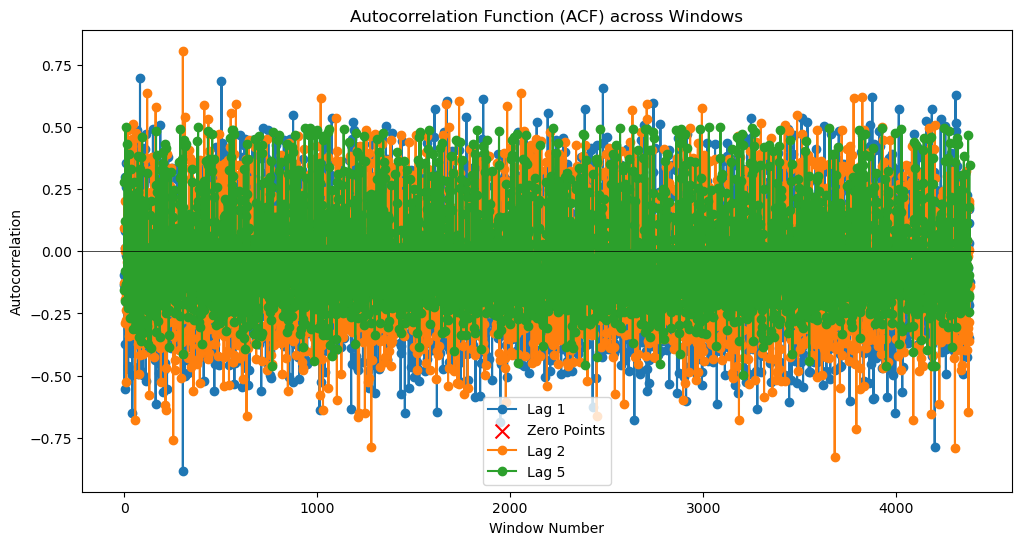

Total windows: 4381
Stable windows: 4361
Stability Score: 99.54%


In [7]:
# Calculate autocorrelation for each window with more lags
def calculate_autocorrelation(y, lag):
    mean_y = np.mean(y)
    numerator = np.sum((y[lag:] - mean_y) * (y[:-lag] - mean_y))
    denominator = np.sum((y - mean_y) ** 2)
    
    return numerator / denominator


# Evaluate ACF for each window at multiple lags
lags = [1, 2, 5]  # You can specify more lags if needed
window_acf_results = {}

for window_num, window_data in execution_times.groupby('Window Number'):
    y = window_data['Execution Time'].values
    acf_values = {}
    for lag in lags:
        if len(y) > lag:  # Ensure sufficient data points for the lag
            acf_values[f'Lag {lag}'] = calculate_autocorrelation(y, lag)
        else:
            acf_values[f'Lag {lag}'] = np.nan  # Assign NaN if not enough data for lag
    window_acf_results[window_num] = acf_values

# Convert results to DataFrame for easier plotting and analysis
acf_df = pd.DataFrame(window_acf_results).T
acf_df.columns = [f'Lag {lag}' for lag in lags]

# Plot the ACF for each lag across all windows
plt.figure(figsize=(12, 6))

for lag in lags:
    acf_values = acf_df[f'Lag {lag}'].copy()
    
    # 替换自相关值为0的点为NaN，以在绘图时产生断点
    acf_values[acf_values == 0] = np.nan  
    
    # 绘制自相关值
    plt.plot(acf_df.index, acf_values, marker='o', label=f'Lag {lag}')

    # 在0值的位置添加标记
    zero_positions = acf_df.index[acf_df[f'Lag {lag}'] == 0]
    plt.scatter(zero_positions, np.zeros_like(zero_positions), color='red', marker='x', s=100, label='Zero Points' if lag == lags[0] else "")

plt.axhline(0, color='black', linewidth=0.5)  # Reference line at 0 for autocorrelation

plt.title('Autocorrelation Function (ACF) across Windows')
plt.xlabel('Window Number')
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()

#The significance of autocorrelation values is often assessed using confidence intervals (e.g., ±2 standard errors). If autocorrelation values fall within these limits, they are typically not considered significant. This is a common approach in time series analysis and can be applied in process mining.

import pandas as pd

# Assuming acf_df is your DataFrame with autocorrelation values calculated for each window

# Initialize a list to keep track of stability for each window
stability_results = []

# Calculate the number of observations (N) for each window
N = 10  # This should be the number of cases per window you defined earlier

# Calculate standard error for each lag and check for significance
for index, row in acf_df.iterrows():
    # Calculate standard error for each lag
    standard_error = 1 / (N**0.5)
    confidence_interval = 2 * standard_error

    # Check if all autocorrelation values are within the confidence interval
    is_stable = all(abs(value) < confidence_interval for value in row[1:])  # Exclude the first column if it's the index
    stability_results.append(is_stable)

# Calculate the number of stable windows
stable_windows_count = sum(stability_results)
total_windows_count = len(stability_results)

# Calculate the stability score as a percentage
stability_score = (stable_windows_count / total_windows_count) * 100

# Print the results
print(f"Total windows: {total_windows_count}")
print(f"Stable windows: {stable_windows_count}")
print(f"Stability Score: {stability_score:.2f}%")


In [8]:
# Initialize lists for storing instability information
unstable_windows = []
unstable_traces = {}

# Loop through each window and check if it contains unstable lags
for window_num, acf_values in window_acf_results.items():
    unstable_lags = []

    for lag, acf_value in acf_values.items():
        # Calculate standard error and confidence interval
        N = 10  # This should be the number of cases per window defined earlier
        standard_error = 1 / (N ** 0.5)
        confidence_interval = 2 * standard_error

        # Check if the ACF value exceeds the confidence interval
        if abs(acf_value) >= confidence_interval:
            unstable_lags.append(lag)
    
    # If any lags are unstable, mark the window as unstable and store trace indices
    if unstable_lags:
        unstable_windows.append(window_num)
        # Collect trace indices and execution times for the current window
        unstable_trace_indices = execution_times[execution_times['Window Number'] == window_num].index.tolist()
        unstable_traces[window_num] = {
            'Trace Indices': unstable_trace_indices,
            'Execution Times': execution_times.loc[unstable_trace_indices, 'Execution Time'].tolist()
        }

# Output results
print("Unstable Windows:", unstable_windows)
print("Unstable Traces by Window:")
for window_num, trace_info in unstable_traces.items():
    print(f"Window {window_num}:")
    print("  Trace Indices:", trace_info['Trace Indices'])
    print("  Execution Times:", trace_info['Execution Times'])


Unstable Windows: [42, 57, 82, 119, 216, 254, 304, 504, 634, 1012, 1030, 1176, 1211, 1217, 1247, 1280, 1454, 1620, 1949, 2055, 2448, 2480, 2643, 3185, 3280, 3681, 3793, 3995, 4088, 4180, 4199, 4304, 4374]
Unstable Traces by Window:
Window 42:
  Trace Indices: [420, 421, 422, 423, 424, 425, 426, 427, 428, 429]
  Execution Times: [24748777.748, 64224985.954, 21920485.571, 60013557.0, 20617641.131, 36163472.0, 26290936.85, 20697787.734, 55965271.672, 20701170.411]
Window 57:
  Trace Indices: [570, 571, 572, 573, 574, 575, 576, 577, 578, 579]
  Execution Times: [25513539.144, 24738371.827, 58442530.775, 51178871.0, 20968660.067, 23731344.223, 51958922.961, 25688328.02, 20959479.307, 39687940.0]
Window 82:
  Trace Indices: [820, 821, 822, 823, 824, 825, 826, 827, 828, 829]
  Execution Times: [65099928.0, 56452860.035, 60359870.397, 45927375.57, 22600555.497, 21393992.048, 21910799.764, 24997965.68, 22521178.369, 24476692.496]
Window 119:
  Trace Indices: [1190, 1191, 1192, 1193, 1194, 1195,

In [9]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def decompose_window(window_data):
    """Decompose the window data into trend and residual components using a moving average."""
    if 'Execution Time' not in window_data.columns:
        return None
    
    execution_time_series = window_data['Execution Time']
    
    # Ensure data is not empty
    if len(execution_time_series) < 2:
        return None
    
    # Apply a simple moving average (for trend)
    moving_average = execution_time_series.rolling(window=3, min_periods=1).mean()
    
    # Calculate residuals (difference between original data and the moving average)
    residuals = execution_time_series - moving_average
    return residuals

def dickey_fuller_test(residuals):
    """Perform the Dickey-Fuller test on residuals and return the p-value."""
    result = adfuller(residuals.dropna())  # Perform ADF test, drop NaN values from residuals
    return result[1]  # p-value is the second item in the result tuple

# Example processing loop for 10-trace windows
window_size = 10
stable_count = 0
unstable_count = 0

# Assume 'execution_times' DataFrame contains the trace data with columns like 'Execution Time' and 'Window Number'
for window_num, window_data in execution_times.groupby('Window Number'):
    print(f"Processing Window {window_num}")
    
    # Decompose the window data and get residuals
    residuals = decompose_window(window_data)
    
    if residuals is not None:
        # Perform the Dickey-Fuller test on the residuals
        p_value = dickey_fuller_test(residuals)
        
        # Classify window as stable or unstable based on p-value
        if p_value < 0.05:
            print(f"Window {window_num} is stable (p-value: {p_value})")
            stable_count += 1
        else:
            print(f"Window {window_num} is unstable (p-value: {p_value})")
            unstable_count += 1

# Calculate final stability score (percentage of stable windows)
total_windows = stable_count + unstable_count
stability_score = (stable_count / total_windows) * 100 if total_windows > 0 else 0

print(f"Stability Score: {stability_score}%")

Processing Window 0
Window 0 is stable (p-value: 0.0024677064690468353)
Processing Window 1
Window 1 is unstable (p-value: 1.0)
Processing Window 2
Window 2 is stable (p-value: 0.006109995994010852)
Processing Window 3
Window 3 is unstable (p-value: 0.49237731729254663)
Processing Window 4
Window 4 is stable (p-value: 0.02969276916176228)
Processing Window 5
Window 5 is unstable (p-value: 0.06769041462765636)
Processing Window 6
Window 6 is stable (p-value: 0.0004060662342478123)
Processing Window 7
Window 7 is unstable (p-value: 0.267543593460303)
Processing Window 8
Window 8 is stable (p-value: 0.0002595337421532452)
Processing Window 9
Window 9 is stable (p-value: 2.3964744765449795e-05)
Processing Window 10
Window 10 is stable (p-value: 0.045698697268182896)
Processing Window 11
Window 11 is stable (p-value: 2.5463903744774713e-09)
Processing Window 12
Window 12 is stable (p-value: 0.005277498746980956)
Processing Window 13
Window 13 is stable (p-value: 0.007771677088820716)
Proces

In [10]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def decompose_window(window_data):
    """Decompose the window data into trend and residual components using a moving average."""
    if 'Execution Time' not in window_data.columns:
        return None
    
    execution_time_series = window_data['Execution Time']
    
    # Ensure data is not empty
    if len(execution_time_series) < 2:
        return None
    
    # Apply a simple moving average (for trend)
    moving_average = execution_time_series.rolling(window=3, min_periods=1).mean()
    
    # Calculate residuals (difference between original data and the moving average)
    residuals = execution_time_series - moving_average
    return residuals

def dickey_fuller_test(residuals):
    """Perform the Dickey-Fuller test on residuals and return the p-value."""
    result = adfuller(residuals.dropna())  # Perform ADF test, drop NaN values from residuals
    return result[1]  # p-value is the second item in the result tuple

# Example processing loop for 10-trace windows
window_size = 10
stable_count = 0
unstable_count = 0

# Assume 'execution_times' DataFrame contains the trace data with columns like 'Execution Time' and 'Window Number'
for window_num, window_data in execution_times.groupby('Window Number'):
    print(f"Processing Window {window_num}")
    
    # Decompose the window data and get residuals
    residuals = decompose_window(window_data)
    
    if residuals is not None:
        # Perform the Dickey-Fuller test on the residuals
        p_value = dickey_fuller_test(residuals)
        
        # Classify window as stable or unstable based on p-value
        if p_value < 0.1:
            print(f"Window {window_num} is stable (p-value: {p_value})")
            stable_count += 1
        else:
            print(f"Window {window_num} is unstable (p-value: {p_value})")
            unstable_count += 1

# Calculate final stability score (percentage of stable windows)
total_windows = stable_count + unstable_count
stability_score = (stable_count / total_windows) * 100 if total_windows > 0 else 0

print(f"Stability Score: {stability_score}%")

Processing Window 0
Window 0 is stable (p-value: 0.0024677064690468353)
Processing Window 1
Window 1 is unstable (p-value: 1.0)
Processing Window 2
Window 2 is stable (p-value: 0.006109995994010852)
Processing Window 3
Window 3 is unstable (p-value: 0.49237731729254663)
Processing Window 4
Window 4 is stable (p-value: 0.02969276916176228)
Processing Window 5
Window 5 is stable (p-value: 0.06769041462765636)
Processing Window 6
Window 6 is stable (p-value: 0.0004060662342478123)
Processing Window 7
Window 7 is unstable (p-value: 0.267543593460303)
Processing Window 8
Window 8 is stable (p-value: 0.0002595337421532452)
Processing Window 9
Window 9 is stable (p-value: 2.3964744765449795e-05)
Processing Window 10
Window 10 is stable (p-value: 0.045698697268182896)
Processing Window 11
Window 11 is stable (p-value: 2.5463903744774713e-09)
Processing Window 12
Window 12 is stable (p-value: 0.005277498746980956)
Processing Window 13
Window 13 is stable (p-value: 0.007771677088820716)
Processi

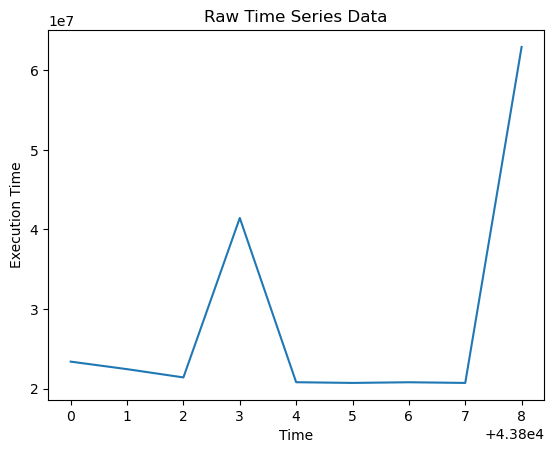

In [12]:
import matplotlib.pyplot as plt

# Plot the raw data
plt.plot(window_data['Execution Time'])
plt.title('Raw Time Series Data')
plt.xlabel('Time')
plt.ylabel('Execution Time')
plt.show()

NameError: name 'stability_score_1' is not defined